In [1]:
#import sys
#!{sys.executable} -m pip install --user alerce

# light_transient_matching
## Matches DESI observations to ALERCE and DECAM ledger objects

This code predominately takes in data from the ALERCE and DECAM ledger brokers and identifies DESI observations within 2 arcseconds of those objects, suspected to be transients. It then prepares those matches to be fed into our [CNN code](https://github.com/MatthewPortman/timedomain/blob/master/cronjobs/transient_matching/modified_cnn_classify_data_gradCAM.ipynb) which attempts to identify the class of these transients.

The main matching algorithm uses astropy's **match_coordinate_sky** to match 1-to-1 targets with the objects from the two ledgers. Wrapping functions handle data retrieval from both the ledgers as well as from DESI and prepare this data to be fed into **match_coordinate_sky**. Since ALERCE returns a small enough (pandas) dataframe, we do not need to precondition the input much. However, DECAM has many more objects to match so we use a two-stage process: an initial 2 degree match to tile RA's/DEC's and a second closer 1 arcsecond match to individual targets. 

As the code is a work in progress, please forgive any redundancies. We are attempting to merge all of the above (neatly) into the same two or three matching/handling functions!

In [2]:
from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, match_coordinates_sky, Angle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import sys

import sqlite3
import os

from desispec.io import read_spectra, write_spectra
from desispec.spectra import Spectra

# Some handy global variables
global db_filename
db_filename = '/global/cfs/cdirs/desi/science/td/daily-search/transients_search.db'
global exposure_path
exposure_path = os.environ["DESI_SPECTRO_REDUX"]
global color_band
color_band = "r"
global minDist
minDist = {}

global today
today = Time.now()

## Necessary functions

In [3]:
# Grabbing the file names
def all_candidate_filenames(transient_dir: str):
    
    # This function grabs the names of all input files in the transient directory and does some python string manipulation
    # to grab the names of the input files with full path and the filenames themselves.

    try:
        filenames_read = glob.glob(transient_dir + "/*.fits") # Hardcoding is hopefully a temporary measure.
    
    except:
        print("Could not grab/find any fits in the transient spectra directory:")
        print(transient_dir)
        filenames_read = [] # Just in case
        #filenames_out = [] # Just in case
        raise SystemExit("Exiting.")
        
    #else:
        #filenames_out = [s.split(".")[0] for s in filenames_read]
        #filenames_out = [s.split("/")[-1] for s in filenames_read]
        #filenames_out = [s.replace("in", "out") for s in filenames_out]
        
    return filenames_read #, filenames_out

#path_to_transient = "/global/cfs/cdirs/desi/science/td/daily-search/desitrip/out"
#print(all_candidate_filenames(path_to_transient)[1])

In [4]:
# From ALeRCE_ledgermaker https://github.com/alercebroker/alerce_client
# I have had trouble importing this before so I copy, paste it, and modify it here.

# I also leave these imports here because why not?
import requests
from alerce.core import Alerce
from alerce.exceptions import APIError

alerce_client = Alerce()

# Choose cone_radius of diameter of tile so that, whatever coord I choose for ra_in, dec_in, we cover the whole tile
def access_alerts(lastmjd_in=[], ra_in = None, dec_in = None, cone_radius = 3600*4.01, classifier='stamp_classifier', class_names=['SN', 'AGN']):
    if type(class_names) is not list:
        raise TypeError('Argument `class_names` must be a list.')
        
    dataframes = []
    if not lastmjd_in:
        date_range = 60
        lastmjd_in = [Time.now().mjd - 60, Time.now().mjd]
        print('Defaulting to a lastmjd range of', str(date_range), 'days before today.')
        
    #print("lastmjd:", lastmjd_in)
    for class_name in class_names:
        data = alerce_client.query_objects(classifier=classifier,
                                           class_name=class_name, 
                                           lastmjd=lastmjd_in,
                                           ra = ra_in,
                                           dec = dec_in,
                                           radius = cone_radius, # in arcseconds
                                           page_size = 5000,
                                           order_by='oid',
                                           order_mode='DESC',                                          
                                           format='pandas')
        
        #if lastmjd is not None:
        #    select = data['lastmjd'] >= lastmjd
        #    data = data[select]
            
        dataframes.append(data)
    
    #print(pd.concat(dataframes).columns)
    return pd.concat(dataframes).sort_values(by = 'lastmjd')

In [5]:
# From https://github.com/desihub/timedomain/blob/master/too_ledgers/decam_TAMU_ledgermaker.ipynb
# Function to grab decam data
from bs4 import BeautifulSoup
import json
import requests
def access_decam_data(url, overwrite=False):
    """Download reduced DECam transient data from Texas A&M.
    Cache the data to avoid lengthy and expensive downloads.
    
    Parameters
    ----------
    url : str
        URL for accessing the data.
    overwrite : bool
        Download new data and overwrite the cached data.
        
    Returns
    -------
    decam_transients : pandas.DataFrame
        Table of transient data.
    """
    folders = url.split('/')
    thedate = folders[-1] if len(folders[-1]) > 0 else folders[-2]
    outfile = '{}.csv'.format(thedate)
    
    if os.path.exists(outfile) and not overwrite:
        # Access cached data.
        decam_transients = pd.read_csv(outfile)
    else:
        # Download the DECam data index.
        # A try/except is needed because the datahub SSL certificate isn't playing well with URL requests.
        try:
            decam_dets = requests.get(url, auth=('decam','tamudecam')).text
        except:
            requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)
            decam_dets = requests.get(url, verify=False, auth=('decam','tamudecam')).text
            
        # Convert transient index page into scrapable data using BeautifulSoup.
        soup = BeautifulSoup(decam_dets)
        
        # Loop through transient object summary JSON files indexed in the main transient page.
        # Download the JSONs and dump the info into a Pandas table.
        decam_transients = None
        j = 0

        for a in soup.find_all('a', href=True):
            if 'object-summary.json' in a:
                link = a['href'].replace('./', '')
                summary_url  = url + link        
                summary_text = requests.get(summary_url, verify=False, auth=('decam','tamudecam')).text
                summary_data = json.loads(summary_text)

                j += 1
                #print('Accessing {:3d}  {}'.format(j, summary_url)) # Modified by Matt

                if decam_transients is None:
                    decam_transients = pd.DataFrame(summary_data, index=[0])
                else:
                    decam_transients = pd.concat([decam_transients, pd.DataFrame(summary_data, index=[0])])
                    
        # Cache the data for future access.
        print('Saving output to {}'.format(outfile))
        decam_transients.to_csv(outfile, index=False)
        
    return decam_transients

In [6]:
# Function to read in fits table info, RA, DEC, MJD and targetid if so desired
# Uses control parameter tile to determine if opening tile exposure file or not since headers are different
import logging

def read_fits_info(filepath: str, tile = True):
    
    '''
    if tile:
        hdu_num = 5
    else:
        hdu_num = 1
    '''
    # Disabling INFO logging temporarily to suppress INFO level output/print from read_spectra
    logging.disable(logging.INFO)
    
    try:
        spec_info = read_spectra(filepath).fibermap
        
        targ_id = spec_info['TARGETID'].data
        targ_ra = spec_info['TARGET_RA'].data # Now it's a numpy array
        targ_dec = spec_info['TARGET_DEC'].data
        targ_mjd = spec_info['LAST_MJD'] #.data
        
        targ_mjd = Time(targ_mjd[0], format = 'mjd')
        #targ_mjd = spec_info['FIRST_MJD'].data[0]
        
        '''
        with fits.open(filepath) as hdu1:
            data_table = Table(hdu1[hdu_num].data) #columns
        
            targ_id = data_table['TARGETID']
            targ_ra = data_table['TARGET_RA'].data # Now it's a numpy array
            targ_dec = data_table['TARGET_DEC'].data
            #targ_mjd = data_table['MJD'][0] some have different versions of this so this is a *bad* idea... at least now I know the try except works!
            
            if tile:
                targ_mjd = hdu1[hdu_num].header['MJD-OBS']
        '''
            
    except:
        filename = filepath.split("/")[-1]
        print("Could not open or use:", filename)
        #print("In path:", filepath)
        #print("Trying the next file...")
        return np.array([]), np.array([]), 0, 0
    
    if not tile and not np.all(targ_mjd):
        print("Unable to grab mjd from spectra, taking it from the filename...")
        targ_mjd = filepath.split("/")[-1].split("_")[-2] #to grab the date
        #targ_mjd = targ_mjd[:4]+"-"+targ_mjd[4:6]+"-"+targ_mjd[6:] # Adding dashes for Time
        targ_mjd = Time(targ_mjd, format = 'mjd') #.mjd
        
    # Re-enabling logging for future calls if necessary
    logging.disable(logging.NOTSET)    
    
    return targ_ra, targ_dec, targ_mjd, targ_id

## Matching function

More or less the prototype to the later rendition used for DECAM. Will not be around in later versions of this notebook as I will be able to repurpose the DECAM code to do both. Planned obsolescence? 

It may not be even worth it at this point... ah well!

In [2]:
# Prototype for the later, heftier matching function
# Will be deprecated, please reference commentary in inner_matching later for operation notes
def matching(path_in: str, max_sep: float, tile = False, date_dict = {}): 
    
    max_sep *= u.arcsec 
    #max_sep = Angle(max_sep*u.arcsec)
    
    #if not target_ra_dec_date:
    #    target_ras, target_decs, obs_mjds = read_fits_ra_dec(path_in, tile)
    #else:
    #    target_ras, target_decs, obs_mjds = target_ra_dec_date
    
    #Look back 60 days from the DESI observations
    days_back = 60
        
    if not date_dict:
        print("No RA's/DEC's fed in. Quitting.")
        return np.array([]), np.array([])
    
    all_trans_matches = []
    all_alerts_matches = []
    targetid_matches = []
    
    for obs_mjd, ra_dec in date_dict.items():
        
        # Grab RAs and DECs from input. 
        target_ras = ra_dec[:, 0]
        target_decs = ra_dec[:, 1]
        target_ids = np.int64(ra_dec[:, 2])

        # Check for NaN's and remove which don't play nice with match_coordinates_sky
        nan_ra = np.isnan(target_ras)
        nan_dec = np.isnan(target_decs)

        if np.any(nan_ra) or np.any(nan_dec):
            print("NaNs found, removing them from array (not FITS) before match.")
            #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
            nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
            target_ras = target_ras[nans] # Logic masking, probably more efficient
            target_decs = target_decs[nans]
            #print("Reduced length (ra, dec):", len(target_ras), len(target_decs))
            
        # Some code used to test -- please ignore ******************
        # Feed average to access alerts, perhaps that will speed things up/find better results
        #avg_ra = np.average(target_ras)
        #avg_dec = np.average(target_decs)
#         coo_trans_search = SkyCoord(target_ras*u.deg, target_decs*u.deg)
#         #print(coo_trans_search)
#         idxs, d2d, _ = match_coordinates_sky(coo_trans_search, coo_trans_search, nthneighbor = 2)
#         # for conesearch in alerce
#         max_sep = np.max(d2d).arcsec + 2.1 # to expand a bit further than the furthest neighbor
#         ra_in = coo_trans_search[0].ra
#         dec_in = coo_trans_search[0].dec
        # Some code used to test -- please ignore ******************        
        
        print([obs_mjd - days_back, obs_mjd])
        try:
            alerts = access_alerts(lastmjd_in = [obs_mjd - days_back, obs_mjd], 
                                   ra_in = target_ras[0], 
                                   dec_in = target_decs[0], #cone_radius = max_sep, 
                                   class_names = ['SN']
                                   ) # Modified Julian Day .mjd
        except:
            #print("No SN matches ("+str(days_back)+" day range) for", obs_mjd)
            #break
            continue
    
        # For each fits file, look at one month before the observation from Alerce
        # Not sure kdtrees matter
        # tree_name = "kdtree_" + str(obs_mjd - days_back)

        alerts_ra = alerts['meanra'].to_numpy()
        #print("Length of alerts: ", len(alerts_ra))
        alerts_dec = alerts['meandec'].to_numpy()

        # Converting to SkyCoord type arrays (really quite handy)
        coo_trans_search = SkyCoord(target_ras*u.deg, target_decs*u.deg)
        coo_alerts = SkyCoord(alerts_ra*u.deg, alerts_dec*u.deg)
        
        # Some code used to test -- please ignore ******************
        #ra_range = list(zip(*[(i, j) for i,j in zip(alerts_ra,alerts_dec) if (np.min(target_ras) < i and i < np.max(target_ras) and np.min(target_decs) < j and j < np.max(target_decs))]))
        #try: 
        #    ra_range = SkyCoord(ra_range[0]*u.deg, ra_range[1]*u.deg)
        #except:
        #    continue
        #print(ra_range)
        #print(coo_trans_search)
        #idx_alerts, d2d_trans, d3d_trans = match_coordinates_sky(coo_trans_search, ra_range)
        #for i in coo_trans_search:
            #print(i.separation(ra_range[3]))
        #print(idx_alerts)
        #print(np.min(d2d_trans))
        #break
        # Some code used to test -- please ignore ******************
        
        idx_alerts, d2d_trans, d3d_trans = match_coordinates_sky(coo_trans_search, coo_alerts, storekdtree = tree_name) # store tree to speed up subsequent results

        # Filtering by maximum separation and closest match
        sep_constraint = d2d_trans < max_sep
        trans_matches = coo_trans_search[sep_constraint]
        alerts_matches = coo_alerts[idx_alerts[sep_constraint]]
        
        targetid_matches = target_ids[sep_constraint]
        
        #print(d2d_trans < max_sep)
        minDist[obs_mjd] = np.min(d2d_trans)

        # Adding everything to lists and outputting
        if trans_matches.size:
            all_trans_matches.append(trans_matches)
            all_alerts_matches.append(alerts_matches)
            sort_dist = np.sort(d2d_trans)
            #print("Minimum distance found: ", sort_dist[0])
            #print()
            #break
        #else:
            #print("No matches found...\n")
            #break

    return all_trans_matches, all_alerts_matches, targetid_matches

## Matching to ALERCE 
Runs a 5 arcsecond match of DESI to Alerce objects. Since everything is handled in functions, this part is quite clean.

From back when I was going to use *if __name__ == "__main__":*... those were the days

In [9]:
if __name__ == "__main__":
    
    # Transient dir
    path_to_transient = "/global/cfs/cdirs/desi/science/td/daily-search/desitrip/out"
    # Grab paths
    paths_to_fits = all_candidate_filenames(path_to_transient)
    #print(len(paths_to_fits))
    
    desi_info_dict = {}
    target_ras, target_decs, obs_mjd, targ_ids = read_fits_info(paths_to_fits[0], tile = False)
    desi_info_dict[obs_mjd] = np.column_stack((target_ras, target_decs, targ_ids))
    
    '''
    To be used when functions are properly combined.
    initial_check(ledger_df = None, ledger_type = '')
    closer_check(matches_dict = {}, ledger_df = None, ledger_type = '', exclusion_list = [])
    '''
    fail_count = 0
    # Iterate through every fits file and grab all necessary info and plop it all together
    for path in paths_to_fits[1:]:
        target_ras, target_decs, obs_mjd, targ_ids = read_fits_info(path, tile = False) 
        
        if not obs_mjd: 
            fail_count += 1
            continue
        
        #try:
        if obs_mjd in desi_info_dict.keys():
            np.append(desi_info_dict[obs_mjd], np.array([target_ras, target_decs, targ_ids]).T, axis = 0)
        else:
            desi_info_dict[obs_mjd] = np.column_stack((target_ras, target_decs, targ_ids))
            #desi_info_dict[obs_mjd].extend((target_ras, target_decs, targ_ids))
        #except:
        #    continue
            #desi_info_dict[obs_mjd] = np.column_stack((target_ras, target_decs, targ_ids))
            #desi_info_dict[obs_mjd].append((target_ras, target_decs, targ_ids))
    #trans_matches, _ = matching(path, 5.0, (all_desi_ras, all_desi_decs, all_obs_mjd))

#     if trans_matches.size:
#         all_trans_matches.append(trans_matches)
#         all_alerts_matches.append(alerts_matches)

Could not open or use: transient_candidate_spectra_20211015_22807.fits
Could not open or use: transient_candidate_spectra_20211015_24137.fits
Could not open or use: transient_candidate_spectra_20211016_23936.fits
Could not open or use: transient_candidate_spectra_20210926_21235.fits
Could not open or use: transient_candidate_spectra_20211016_25411.fits
Could not open or use: transient_candidate_spectra_20211105_21543.fits
Could not open or use: transient_candidate_spectra_20210926_25240.fits
Could not open or use: transient_candidate_spectra_20211013_24409.fits
Could not open or use: transient_candidate_spectra_20211107_82268.fits
Could not open or use: transient_candidate_spectra_20210208_80721.fits
Could not open or use: transient_candidate_spectra_20211107_22426.fits


In [12]:
#print([i.mjd for i in sorted(desi_info_dict.keys())])
print(len(desi_info_dict))
print(fail_count)

670
415


In [41]:
# I was going to prepare everything by removing duplicate target ids but it's more trouble than it's worth and match_coordinates_sky can handle it
# Takes quite a bit of time... not much more I can do to speed things up though since querying Alerce for every individual date is the hang-up.
#print(len(paths_to_fits) - ledesi_info_dictfo_dict))
#print(fail_count)

#trans_matches, _, target_id_matches = matching("", 2.0, date_dict = temp_dict)
trans_matches, _, target_id_matches = matching("", 2.0, date_dict = desi_info_dict)

print(trans_matches)
print(target_id_matches)

[]
[]


## Matching to DECAM functions

In [12]:
# Grabbing the frame fits files
def glob_frames(exp_d: str):    
    # This function grabs the names of all input files in the transient directory and does some python string manipulation
    # to grab the names of the input files with full path and the filenames themselves.

    try:
        filenames_read = glob.glob(exp_d + "/cframe-" + color_band + "*.fits") # Only need one of b, r, z
        # sframes not flux calibrated
        # May want to use tiles... coadd (will need later, but not now)
    
    except:
        print("Could not grab/find any fits in the exposure directory:")
        print(exp_d)
        filenames_read = [] # Just in case
        #filenames_out = [] # Just in case
        raise SystemExit("Exiting.")
        
    #else:
        #filenames_out = [s.split(".")[0] for s in filenames_read]
        #filenames_out = [s.split("/")[-1] for s in filenames_read]
        #filenames_out = [s.replace("in", "out") for s in filenames_out]
        
    return filenames_read #, filenames_out

#path_to_transient = "/global/cfs/cdirs/desi/science/td/daily-search/desitrip/out"
#print(all_candidate_filenames(path_to_transient)[1])

## Match handling routines

The two functions below perform data handling/calling for the final match step. 

The first, **initial_check** grabs all the tile RAs and DECS from the exposures and tiles SQL table, does some filtering, and sends the necessary information to the matching function. Currently designed to handle ALERCE as well but work has to be done to make sure it operates correctly.

In [281]:
def initial_check(ledger_df = None, ledger_type = ''):

    query_date_start = "20210301"
    
    #today = Time.now()
    smushed_YMD = today.iso.split(" ")[0].replace("-","")
    
    query_date_end = smushed_YMD 

    # Handy queries for debugging/useful info
    query2 = "PRAGMA table_info(exposures)"
    query3 = "PRAGMA table_info(tiles)"
    # Crossmatch across tiles and exposures to grab obsdate via tileid
    query_match = "SELECT distinct tilera, tiledec, obsdate, obsmjd, expid, exposures.tileid from exposures INNER JOIN tiles ON exposures.tileid = tiles.tileid where obsdate BETWEEN " + \
        query_date_start + " AND " + query_date_end + ";" 
    
    '''
    Some handy code for debugging
    #cur.execute(query2)
    #row2 = cur.fetchall()
    #for i in row2:
    #    print(i[:])

    '''
    
    # Querying sql and returning a data type called sqlite3 row, it's kind of like a namedtuple/dictionary
    conn = sqlite3.connect(db_filename)

    conn.row_factory = sqlite3.Row # https://docs.python.org/3/library/sqlite3.html#sqlite3.Row

    cur = conn.cursor()

    cur.execute(query_match)
    matches_list = cur.fetchall()
    cur.close()

    # I knew there was a way! THANK YOU!
    # https://stackoverflow.com/questions/11276473/append-to-a-dict-of-lists-with-a-dict-comprehension
    
    # Grabbing everything by obsdate from matches_list
    date_dict = {k['obsdate'] : list(filter(lambda x:x['obsdate'] == k['obsdate'], matches_list)) for k in matches_list}

    alert_matches_dict = {}

    all_trans_matches = []
    all_alerts_matches = []
    
    # Grabbing DECAM ledger if not already fed in
    if ledger_type.upper() == 'DECAM_TAMU':
        if ledger_df.empty:
            ledger_df = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/')

    # Iterating through the dates and checking each tile observed on each date
    # It is done in this way to cut down on calls to ALERCE since we go day by day
    # It's also a convenient way to organize things
    for date, row in date_dict.items():
        
        date_str = str(date)
        date_str = date_str[:4]+"-"+date_str[4:6]+"-"+date_str[6:] # Adding dashes for Time
        obs_mjd = Time(date_str).mjd

        # This method is *technically* safer than doing a double list comprehension with set albeit slower
        # The lists are small enough that speed shouldn't matter here
        unique_tileid = {i['tileid']: (i['tilera'], i['tiledec']) for i in row}
        exposure_ras, exposure_decs = zip(*unique_tileid.values())
        # Grabbing alerce ledger if not done already
        if ledger_type.upper() == 'ALERCE':
            if ledger_df.empty:
                ledger_df = access_alerts(lastmjd = obs_mjd - 28) # Modified Julian Day #.mjd
        elif ledger_type.upper() == 'DECAM_TAMU':
            pass
        else:
            print("Cannot use alerts broker/ledger provided. Stopping before match.")
            return {}

        #Reatin tileid
        tileid_arr = np.array(list(unique_tileid.keys())) 

        # Where the magic/matching happens
        trans_matches, alert_matches, trans_ids, alerts_ids, _ = \
            inner_matching(target_ids_in = tileid_arr, target_ras_in = exposure_ras, target_decs_in = exposure_decs, obs_mjd_in = obs_mjd, 
            path_in = '', max_sep = 1.8, sep_units = 'deg', ledger_df_in = ledger_df, ledger_type_in = ledger_type)
        
        # Add everything into one giant list for both
        if trans_matches.size:
            #print(date, "-", len(trans_matches), "matches")
            all_trans_matches.append(trans_matches)
            all_alerts_matches.append(alert_matches)
        else:
            #print("No matches on", date)
            continue

        # Prepping output
        # Populating the dictionary by date (a common theme)
        # Each element in the dictionary thus contains the entire sqlite3 row (all info from sql tables with said headers)
        alert_matches_dict[date] = []

        for tup in trans_matches:
            ra = tup.ra.deg
            dec = tup.dec.deg
            match_rows = [i for i in row if (i['tilera'], i['tiledec']) == (ra, dec)] # Just rebuilding for populating, this shouldn't change/exclude anything
            alert_matches_dict[date].extend(match_rows)
            
    return alert_matches_dict

## closer_check
**closer_check** is also a handling function but operates differently in that now it is checking individual targets. This *must* be run after **initial_check** because it takes as input the dictionary **initial_check** spits out. It then grabs all the targets from the DESI files and pipes that into the matching function but this time with a much more strict matching radius (in this case 2 arcseconds). 

It then preps the data for output and writing.

In [276]:
def closer_check(matches_dict = {}, ledger_df = None, ledger_type = '', exclusion_list = []):
    all_exp_matches = {}
        
    if not matches_dict:
        print("No far matches fed in for nearby matching. Returning none.")
        return {}
    
    # Again just in case the dataframe isn't fed in
    if ledger_type.upper() == 'DECAM_TAMU':
        
        id_head = 'ObjectID'
        ra_head = 'RA-OBJECT'
        dec_head = 'DEC-OBJECT'
        
        if ledger_df.empty:
            ledger_df = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/')
    
    count_flag=0
    # Iterating through date and all tile information for that date
    for date, row in matches_dict.items(): 
        print("\n", date)
        if date in exclusion_list:
            continue

        # Declaring some things
        all_exp_matches[date] = []
        alert_exp_matches = []
        file_indices = {}

        all_targ_ras = np.array([])
        all_targ_decs = np.array([])
        all_targ_ids = np.array([])
        all_tileids = np.array([])
        all_petals = np.array([])

        # Iterating through each initial match tile for every date
        for i in row:
            # Grabbing the paths and iterating through them to grab the RA's/DEC's
            exp_paths = '/'.join((exposure_path, "daily/exposures", str(i['obsdate']), "000"+str(i['expid'])))
            #print(exp_paths)
            for path in glob_frames(exp_paths):
                #print(path)
                targ_ras, targ_decs, _, targ_ids = read_fits_info(path, tile = True)
                
                h=fits.open(path)
                tileid = h[0].header['TILEID']
                tileids = np.full(len(targ_ras),tileid).tolist()
                petal = path.split("/")[-1].split("-")[1][-1]
                petals = np.full(len(targ_ras),petal).tolist()

                # This is to retain the row to debug/check the original FITS file
                # And to pull the info by row direct if you feel so inclined
                all_len = len(all_targ_ras)
                new_len = len(targ_ras)
                if all_len:
                    all_len -= 1
                    file_indices[path] = (all_len, all_len + new_len) # The start and end index, modulo number
                else:
                    file_indices[path] = (0, new_len) # The start and end index, modulo number

                if len(targ_ras) != len(targ_decs):
                    print("Length of all ras vs. all decs do not match.")
                    print("Something went wrong!")
                    print("Continuing but not adding those to match...")
                    continue

                # All the ras/decs together!
                all_targ_ras = np.append(all_targ_ras, targ_ras)
                all_targ_decs = np.append(all_targ_decs, targ_decs)
                all_targ_ids = np.append(all_targ_ids, targ_ids)
                all_tileids = np.append(all_tileids, tileids)
                all_petals = np.append(all_petals, petals)

        date_mjd = str(date)[:4]+"-"+str(date)[4:6] + "-" + str(date)[6:] # Adding dashes for Time
        date_mjd = Time(date_mjd).mjd
        
        # Grabbing ALERCE just in case
        # Slow
        if ledger_type.upper() == 'ALERCE':
            
            id_head = 'oid'
            ra_head = 'meanra'
            dec_head = 'meandec'
            
            if ledger_df.empty:
                ledger_df = access_alerts(lastmjd_in = obs_mjd - 45) # Modified Julian Day #.mjd
                
        # Checking for NaNs, again doesn't play nice with match_coordinates_sky
        nan_ra = np.isnan(all_targ_ras)
        nan_dec = np.isnan(all_targ_decs)
    
        if np.any(nan_ra) or np.any(nan_dec):
            print("NaNs found, removing them from array before match.")
            #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
            nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
            all_targ_ras = all_targ_ras[nans] # Logic masking, probably more efficient
            all_targ_decs = all_targ_decs[nans]
            all_targ_ids = all_targ_ids[nans]
            all_tileids = all_tileids[nans]
            all_petals = all_petals[nans]
        
        # Where the magic matching happens. This time with separation 2 arcseconds.
        # Will be cleaned up (eventually)
        alert_exp_matches, alerts_matches, targetid_exp_matches, id_alerts_matches, exp_idx = inner_matching(target_ids_in =all_targ_ids, \
                        target_ras_in = all_targ_ras, target_decs_in = all_targ_decs, obs_mjd_in = date_mjd, 
                        path_in = '', max_sep = 2, sep_units = 'arcsec', ledger_df_in = ledger_df, ledger_type_in = ledger_type)
        
        date_arr=np.full(alerts_matches.shape[0],date)
        #print(date_arr.shape,targetid_exp_matches.shape,alert_exp_matches.shape, id_alerts_matches.shape,alerts_matches.shape )
        info_arr_date=np.column_stack((date_arr,all_tileids[exp_idx],all_petals[exp_idx], targetid_exp_matches,alert_exp_matches.ra.deg,alert_exp_matches.dec.deg, \
                                       id_alerts_matches,alerts_matches.ra.deg,alerts_matches.dec.deg ))
        all_exp_matches[date].append(info_arr_date)
        
        if count_flag==0: 
            all_exp_matches_arr=info_arr_date
            count_flag=1
        else: 
            #print(all_exp_matches_arr,info_arr_date)
            all_exp_matches_arr=np.concatenate((all_exp_matches_arr,info_arr_date))
    
    # Does not easily output to a csv since we have multiple results for each date
    # so uh... custom file output for me
    return all_exp_matches_arr

## inner_matching
#### aka the bread & butter
**inner_matching** is what ultimately does the final match and calls **match_coordinates_sky** with everything fed in. So really it doesn't do much other than take in all the goodies and make everyone happy.

It may still be difficult to co-opt for alerce matching but that may be a project for another time.

In [256]:
def inner_matching(target_ids_in = np.array([]), target_ras_in = np.array([]), target_decs_in = np.array([]), obs_mjd_in = '', path_in = '', max_sep = 2, sep_units = 'arcsec', ledger_df_in = None, ledger_type_in = ''): # to be combined with the other matching thing in due time
    
    # Figuring out the units
    if sep_units == 'arcsec':
        max_sep *= u.arcsec
    elif sep_units == 'arcmin':
        max_sep *= u.arcmin
    elif sep_units == 'deg':
        max_sep *= u.deg
    else:
        print("Separation unit specified is invalid for matching. Defaulting to arcsecond.")
        max_sep *= u.arcsec
        
    if not np.array(target_ras_in).size:
        return np.array([]), np.array([])
    
    # Checking for NaNs, again doesn't play nice with match_coordinates_sky
    nan_ra = np.isnan(target_ras_in)
    nan_dec = np.isnan(target_decs_in)
    
    if np.any(nan_ra) or np.any(nan_dec):
        print("NaNs found, removing them from array before match.")
        #print("Original length (ra, dec): ", len(target_ras), len(target_decs))
        nans = np.logical_not(np.logical_and(nan_ra, nan_dec))
        target_ras_in = target_ras_in[nans] # Logic masking, probably more efficient
        target_decs_in = target_decs_in[nans]
        target_ids_in = target_ids_in[nans]
        
        #print("Reduced length (ra, dec):", len(target_ras), len(target_decs))

    # For quick matching if said kdtree actually does anything
    # Supposed to speed things up on subsequent runs *shrugs*
    tree_name = "_".join(("kdtree", ledger_type_in, str(obs_mjd_in)))
    
    # Selecting header string to use with the different alert brokers/ledgers
    if ledger_type_in.upper() == 'DECAM_TAMU':
        id_head = 'ObjectID'
        ra_head = 'RA-OBJECT'
        dec_head = 'DEC-OBJECT'
    
    elif ledger_type_in.upper() == 'ALERCE':
        id_head = 'oid' #Check this is how id is called!
        ra_head = 'meanra'
        dec_head = 'meandec'
        
    else:
        print("No ledger type specified. Quitting.") 
        # lofty goals
        # Will try to figure it out assuming it's a pandas dataframe.")
        #print("Returning empty-handed for now until that is complete - Matthew P.")
        return np.array([]), np.array([])
    
    # Convert df RA/DEC to numpy arrays
    alerts_id = ledger_df_in[id_head].to_numpy()
    alerts_ra = ledger_df_in[ra_head].to_numpy()
    alerts_dec = ledger_df_in[dec_head].to_numpy()

    # Convert everything to SkyCoord
    coo_trans_search = SkyCoord(target_ras_in*u.deg, target_decs_in*u.deg)
    coo_alerts = SkyCoord(alerts_ra*u.deg, alerts_dec*u.deg)

    # Do the matching! 
    idx_alerts, d2d_trans, d3d_trans = match_coordinates_sky(coo_trans_search, coo_alerts, storekdtree = tree_name) # store tree to speed up subsequent results

    # Filter out the good stuff
    sep_constraint = d2d_trans < max_sep
    trans_matches = coo_trans_search[sep_constraint]
    trans_matches_ids = target_ids_in[sep_constraint]
    alerts_matches = coo_alerts[idx_alerts[sep_constraint]]
    alerts_matches_ids = alerts_id[idx_alerts[sep_constraint]]
    
    if trans_matches.size:
        print(len(trans_matches), "matches with separation -", max_sep)
        #sort_dist = np.sort(d2d_trans)
        #print("Minimum distance found: ", sort_dist[0])

    return trans_matches, alerts_matches, trans_matches_ids, alerts_matches_ids, sep_constraint

## Grab DECAM ledger as pandas dataframe

In [52]:
decam_transients = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy/', overwrite = True) # If True, grabs a fresh batch

Saving output to LCData_Legacy.csv


In [ ]:
decam_transients_agn = access_decam_data('https://datahub.geos.tamu.edu:8000/decam/LCData_Legacy_AGN/', overwrite = True) # If True, grabs a fresh batch

In [61]:
decam_transients

,ObjectID,RA-OBJECT,DEC-OBJECT,NumberAlerts,MaxSCORE,RA-PSEUDO-HOST,DEC-PSEUDO-HOST,SEP-PSEUDO-HOST,RA-NEIGHBOR-STAR,DEC-NEIGHBOR-STAR,...,Discovery-Round,Discovery-Time,Discovery-Filter,Discovery-Magnitude,Discovery-SNR,Latest-Round,Latest-Time,Latest-Filter,Latest-Magnitude,Latest-SNR
0,A202103221407558m001825,211.982786,-0.306951,12,0.972,211.982614,-0.306946,0.6199,211.983372,-0.306315,...,0,2021-03-22T06:40:19.074,N,22.13,19.2,9,2021-04-18T05:37:55.763,N,22.86,10.2
0,A202103221408139m033502,212.057952,-3.583947,28,0.954,212.057864,-3.583960,0.3199,212.058798,-3.586276,...,0,2021-03-22T08:20:58.209,N,21.78,25.7,23,2021-06-02T06:00:51.873,N,21.82,18.1
0,A202103221408412p002445,212.171737,0.412527,49,0.998,212.171673,0.412394,0.5317,212.174697,0.411566,...,0,2021-03-22T06:36:50.928,S,20.61,36.2,23,2021-06-02T02:59:21.867,S,21.46,33.9
0,A202103221408578m005300,212.241200,-0.883300,2,0.855,212.241200,-0.883400,0.3000,212.239800,-0.884900,...,0,2021-03-22T08:17:30.880,S,22.55,15.5,1,2021-03-24T07:10:51.368,S,22.33,25.6
0,A202103221409059m023156,212.274757,-2.532478,21,0.969,212.274533,-2.532531,0.8290,212.275356,-2.535003,...,0,2021-03-22T08:14:02.747,N,22.27,10.6,18,2021-05-18T03:17:17.544,N,22.99,8.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,T202106021437535m004239,219.473273,-0.710944,6,0.973,219.473277,-0.711253,1.1100,219.473195,-0.714488,...,23,2021-06-02T02:37:33.855,N,21.46,30.6,24,2021-06-05T02:15:30.763,N,21.44,19.8
0,T202106021440559m025615,220.233290,-2.937658,4,0.940,220.233839,-2.935933,6.5148,220.230799,-2.938535,...,23,2021-06-02T05:33:59.097,S,22.14,13.6,23,2021-06-02T05:40:21.261,S,22.36,14.0
0,T202106021442286m035936,220.619578,-3.993391,3,0.935,220.618952,-3.993328,2.2614,220.615993,-3.991748,...,23,2021-06-02T05:33:59.097,N,22.15,22.5,23,2021-06-02T05:36:54.041,N,22.07,10.5
0,T202106021449003p003225,222.251305,0.540528,7,0.984,222.251090,0.540740,1.0845,222.249251,0.544256,...,23,2021-06-02T02:27:20.976,S,21.04,47.1,24,2021-06-05T02:06:24.397,S,21.21,18.4


## Run initial check (on tiles) and closer check (on targets)

In [146]:
init_matches_by_date = initial_check(ledger_df = decam_transients, ledger_type = 'DECAM_TAMU')

2 matches with separation - 1.8 deg
1 matches with separation - 1.8 deg
8 matches with separation - 1.8 deg
5 matches with separation - 1.8 deg
10 matches with separation - 1.8 deg
2 matches with separation - 1.8 deg
6 matches with separation - 1.8 deg
9 matches with separation - 1.8 deg
2 matches with separation - 1.8 deg
6 matches with separation - 1.8 deg
6 matches with separation - 1.8 deg
3 matches with separation - 1.8 deg
4 matches with separation - 1.8 deg
12 matches with separation - 1.8 deg
9 matches with separation - 1.8 deg
5 matches with separation - 1.8 deg
3 matches with separation - 1.8 deg
3 matches with separation - 1.8 deg
1 matches with separation - 1.8 deg
1 matches with separation - 1.8 deg
7 matches with separation - 1.8 deg
3 matches with separation - 1.8 deg
8 matches with separation - 1.8 deg
8 matches with separation - 1.8 deg
9 matches with separation - 1.8 deg
12 matches with separation - 1.8 deg
10 matches with separation - 1.8 deg
4 matches with separatio

In [279]:
close_matches = closer_check(init_matches_by_date, ledger_df = decam_transients, ledger_type = 'DECAM_TAMU', exclusion_list = [])
np.save('matches_DECam',close_matches, allow_pickle=True)


 20210322
8 matches with separation - 2.0 arcsec

 20210402
2 matches with separation - 2.0 arcsec

 20210405
NaNs found, removing them from array before match.
24 matches with separation - 2.0 arcsec

 20210406
NaNs found, removing them from array before match.
15 matches with separation - 2.0 arcsec

 20210407
NaNs found, removing them from array before match.
33 matches with separation - 2.0 arcsec

 20210408
NaNs found, removing them from array before match.
4 matches with separation - 2.0 arcsec

 20210409
NaNs found, removing them from array before match.
7 matches with separation - 2.0 arcsec

 20210410
NaNs found, removing them from array before match.
40 matches with separation - 2.0 arcsec

 20210411
NaNs found, removing them from array before match.

 20210412
NaNs found, removing them from array before match.
5 matches with separation - 2.0 arcsec

 20210413
NaNs found, removing them from array before match.
9 matches with separation - 2.0 arcsec

 20210414
NaNs found, rem

In [282]:
init_matches_agn_by_date = initial_check(ledger_df = decam_transients_agn, ledger_type = 'DECAM_TAMU')
close_matches_agn = closer_check(init_matches_agn_by_date, ledger_df = decam_transients_agn, ledger_type = 'DECAM_TAMU', exclusion_list = [])
np.save('matches_DECam_agn',close_matches_agn, allow_pickle=True)

2 matches with separation - 1.8 deg
1 matches with separation - 1.8 deg
8 matches with separation - 1.8 deg
5 matches with separation - 1.8 deg
10 matches with separation - 1.8 deg
2 matches with separation - 1.8 deg
6 matches with separation - 1.8 deg
9 matches with separation - 1.8 deg
2 matches with separation - 1.8 deg
6 matches with separation - 1.8 deg
6 matches with separation - 1.8 deg
3 matches with separation - 1.8 deg
4 matches with separation - 1.8 deg
12 matches with separation - 1.8 deg
9 matches with separation - 1.8 deg
5 matches with separation - 1.8 deg
3 matches with separation - 1.8 deg
3 matches with separation - 1.8 deg
1 matches with separation - 1.8 deg
1 matches with separation - 1.8 deg
7 matches with separation - 1.8 deg
3 matches with separation - 1.8 deg
8 matches with separation - 1.8 deg
8 matches with separation - 1.8 deg
9 matches with separation - 1.8 deg
12 matches with separation - 1.8 deg
10 matches with separation - 1.8 deg
4 matches with separatio

In [295]:
np.save('matches_DECam_agn',close_matches_agn, allow_pickle=True)

## A quick plot to see the distribution of target matches

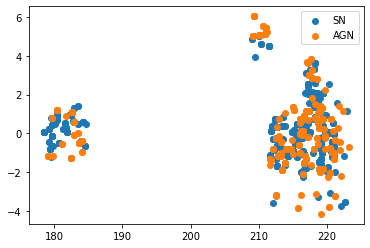

In [286]:
plt.scatter(close_matches[:,4], close_matches[:,5],label='SN')
plt.scatter(close_matches_agn[:,4], close_matches_agn[:,5],label='AGN')
plt.legend()

## End notes:
Double matches are to be expected, could be worthwhile to compare the spectra of both